# concept

After applying infomap to the transition matrix, we want to get tracking results in the form of infomap cluster timeseries


# imports 

In [2]:
import numpy as np
np.set_printoptions(suppress=True)
import h5py
import pandas as pd
import time
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import img2pdf
import os
import sys
%matplotlib widget
%load_ext autoreload
%autoreload 2

# --- import functions for computing kinematic variables --- #
sys.path.append('../tracking_code/lib/')
sys.path.append('./lib/')

from tracking import contiguous_regions

# adding the infomap libs
from infomap_utils import make_dictionary_of_state_numberings, find_binIdxs_for_timeseries
from infomap_utils import build_transition_matrix, apply_infomap_clustering_to_transition_matrix
from infomap_utils import make_binTuple_to_clusterIdx_dict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load the tracking data

In [4]:
main_load_folder = '/media/liam/hd1/fighting_data/tracking_results/'

# ----------------------#

interp_polyOrd=1  # the order of the polynomial used for interpolation
interp_limit=5    # the maximum number of frames to interpolate over
savgol_win=9      # the number of frames for the Savitzky-Golay filter
savgol_ord=2      # the polynomial order for the Savitzky-Golay filter
dt=0.01           # the frame rate of the recording


# the filepaths for loading the infomap timeseries data we need
infomap_data_loadpath = os.path.join( os.path.dirname(os.path.dirname(main_load_folder)) , 
                                      'infomap_data/transmat_and_infomap.h5')

# the path for loading the fightbout info
fightBouts_info_path = os.path.join(main_load_folder, 'fightBouts.h5')


# -----------------------#

loadpaths = glob.glob(os.path.join(main_load_folder, '*results.h5'))
loadpaths.sort()

# parse the exp names
expNames = [path.split('/')[-1][:23] for path in loadpaths]


raw_trajectories = []
for path in loadpaths:
    with h5py.File(path, 'r') as hf:
        tracks_3D_raw = hf['tracks_3D_raw'][:]
    raw_trajectories.append(tracks_3D_raw)

smooth_trajectories = []
for path in loadpaths:
    with h5py.File(path, 'r') as hf:
        tracks_3D_smooth = hf['tracks_3D_smooth'][:]
    smooth_trajectories.append(tracks_3D_smooth)
    
    
# create a list of the number of frames in each experiment
expNumFrames = []
for expIdx in range(len(expNames)):
    nfs = smooth_trajectories[expIdx].shape[0]
    expNumFrames.append(nfs)
    
# -----------------------------#
# load other useful information
    
other_info_loadpath = os.path.join(main_load_folder, 'winners_losers_inconclusive.h5')
with h5py.File(other_info_loadpath, 'r') as hf:
    winner_idxs = hf['winner_idxs'][:]
    loser_idxs = hf['loser_idxs'][:]
    conclusive_winner_loser = hf['conclusive_winner_loser'][:]
    already_established_dominance = hf['already_established_dominance'][:]


with h5py.File(fightBouts_info_path, 'r') as hf:
    fight_bout_info = hf['fight_bout_info'][:]
    fight_bout_info_noDurThresh = hf['fight_bout_info_noDurThresh'][:]
    
    
    


# Compute kin vars for all experiments

In [5]:
from kinematics import compute_pec_pec_distance, compute_thetaW_and_thetaL
from kinematics import compute_signed_pec_z_difference, compute_phi_dot_from_raw_trajectories, compute_coordinate_origin_z
from kinematics import compute_pec_pec_distance_dot, compute_coordinate_origin_z_dot

In [6]:
interp_polyOrd=1  # the order of the polynomial used for interpolation
interp_limit=5    # the maximum number of frames to interpolate over
savgol_win=9      # the number of frames for the Savitzky-Golay filter
savgol_ord=2      # the polynomial order for the Savitzky-Golay filter
dt=0.01           # the frame rate of the recording

In [7]:
t0 = time.perf_counter()

exp_dpps = []
exp_tetWs = []
exp_tetLs = []

exp_phi_dots = []
exp_dpp_dots = []
exp_pec_z_differences = []
exp_Oz_dots = []


for ii, expName in enumerate(expNames):
    print(expName)
    
    smooth_traj = smooth_trajectories[ii]
    raw_traj = raw_trajectories[ii]
    winIdx = winner_idxs[ii]
    losIdx = loser_idxs[ii]
    
    dpp_ts = compute_pec_pec_distance(smooth_traj)
    tetW_ts, tetL_ts = compute_thetaW_and_thetaL(smooth_traj, winIdx, losIdx)
    exp_dpps.append(dpp_ts)
    exp_tetWs.append(tetW_ts)
    exp_tetLs.append(tetL_ts)
    
    
    phi_dot = compute_phi_dot_from_raw_trajectories(raw_traj, winIdx, losIdx, dt=dt,
                                                    interp_max_gap=interp_limit, interp_polyOrd=interp_polyOrd,
                                                    smooth_polyOrd=savgol_ord, smooth_winSize=savgol_win)
    exp_phi_dots.append(phi_dot)
    
    
    signed_pec_z_difference = compute_signed_pec_z_difference(smooth_traj, winIdx, losIdx)
    exp_pec_z_differences.append(signed_pec_z_difference)
    
    dpp_dot = compute_pec_pec_distance_dot(raw_traj,  dt=dt,
                                            interp_max_gap=interp_limit, interp_polyOrd=interp_polyOrd,
                                            smooth_polyOrd=savgol_ord, smooth_winSize=savgol_win)
    exp_dpp_dots.append(dpp_dot)
    
    
    Oz_dot = compute_coordinate_origin_z_dot(raw_traj, winIdx, losIdx, dt=dt,
                                             interp_max_gap=interp_limit, interp_polyOrd=interp_polyOrd, 
                                             smooth_polyOrd=savgol_ord, smooth_winSize=savgol_win)
    exp_Oz_dots.append(Oz_dot)
    
    
tE = time.perf_counter()
print()
print('finished: {0} s'.format(tE-t0))

FishTank20200127_143538


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200129_140656


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200130_153857


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200130_181614


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200207_161445


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200213_154940


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200214_153519


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200217_160052


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200218_153008


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200316_163320


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200327_154737


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200330_161100


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200331_162136


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200520_152810


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200521_154541


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200525_161602


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200526_160100


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:24: RuntimeWarning: invalid value encountered in true_divide
  vec_ts = vec_ts / row_norms[:, np.newaxis]
/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200527_152401
FishTank20200824_151740


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200828_155504


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200902_160124


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]


FishTank20200903_160946


/home/liam/code/Dynamics_of_dominance/figures_code/../tracking_code/lib/kinematics.py:218: RuntimeWarning: invalid value encountered in true_divide
  winnerPec_to_loserPec = winnerPec_to_loserPec / row_norms[:, np.newaxis]



finished: 19.444452458061278 s


In [8]:
# --- Master sets of plotting --- #
dpp_dot_master = np.concatenate(exp_dpp_dots)
phi_dot_master = np.concatenate(exp_phi_dots)
pec_z_difference_master = np.concatenate(exp_pec_z_differences)
Oz_dots_master = np.concatenate(exp_Oz_dots)

# Load the main infomap results

In [11]:
infomap_data_loadpath

'/media/liam/hd1/fighting_data/infomap_data/transmat_and_infomap.h5'

In [9]:

## VIEW THE CONTENTS ##
# with h5py.File(infomap_data_loadpath, 'r') as hf:
#     for key in hf.keys():
#         print(key)

In [12]:
## Load the main data saved in the h5 file ##

with h5py.File(infomap_data_loadpath, 'r') as hf:
    tseries = hf['tseries'][:]
    transition_matrix = hf['edited_transition_matrix'][:]
    dpp_bins = hf['dpp_bins'][:]
    tet_w_bins = hf['tet_w_bins'][:]
    tet_l_bins = hf['tet_l_bins'][:]
    numClusters = hf['numClusters'][()]
    # other
    NaN_row_bin_tup_arr = hf['NaN_row_bin_tup_arr'][:]
    NaN_row_idxs = hf['NaN_row_idxs'][:] 
    numInfoTrials = hf['numInfoTrials'][()]
    tau = hf['tau'][()]
    transMat_row_bin_tup_arr  = hf['transMat_row_bin_tup_arr'][:]
    
cluster_state_tuples = []
cluster_state_idxs = []
with h5py.File(infomap_data_loadpath, 'r') as hf:
    for clusterIdx in range(numClusters):
        st_idxs = hf['cluster_state_idxs/cluster{0}'.format(clusterIdx)][:]
        st_tups = hf['cluster_state_tuples/cluster{0}'.format(clusterIdx)][:]
        cluster_state_idxs.append(st_idxs)
        cluster_state_tuples.append(st_tups)
        
num_tetW_bins = tet_w_bins.shape[0]-1
num_tetL_bins = tet_l_bins.shape[0]-1
num_dpp_bins = dpp_bins.shape[0]-1


numStates = num_tetW_bins*num_tetL_bins*num_dpp_bins

binTuple_to_clusterIdx_dict = make_binTuple_to_clusterIdx_dict(cluster_state_tuples)

print(loadpath)
print(numStates)
print(numClusters)

/media/liam/hd1/fighting_data/infomap_data/transmat_and_infomap.h5
8000
56


# Convert timeseries to clusterIdxs

In [27]:
## There are two sections, compute and load
#
# You only need to compute once, from then on you can load.

## compute

In [13]:
loadpath

'/media/liam/hd1/fighting_data/infomap_data/transmat_and_infomap.h5'

In [14]:
# set a path to save the cluster timeseries
all_cluster_tseries_savepath = os.path.join(os.path.dirname(loadpath), 'exp_clusterIdx_timeseries.h5')
all_cluster_tseries_savepath

'/media/liam/hd1/fighting_data/infomap_data/exp_clusterIdx_timeseries.h5'

In [35]:

t0 = time.perf_counter()

        
        
## --- load the tet_tet_beta_beta data --- ##
all_exps_tetW_tetL_dpp_tseries = []
for expIdx in range(len(expNames)):
    dpp = exp_dpps[expIdx]
    tetw = exp_tetWs[expIdx]
    tetl = exp_tetLs[expIdx]
    tettetdpp = np.stack([tetw, tetl, dpp], axis=1)
    all_exps_tetW_tetL_dpp_tseries.append(tettetdpp)
        
        


## --- create the cluster timeseries --- ##

# get the bintuples for each experiment
all_exps_tettetdpp_bintuples_tseries = []
for expIdx in range(len(expNames)):
    exp_tet_tet_dpp_tseries = np.copy(all_exps_tetW_tetL_dpp_tseries[expIdx])
    exp_tetW_bin_idxs = find_binIdxs_for_timeseries(exp_tet_tet_dpp_tseries[:,0], tet_w_bins)
    exp_tetL_bin_idxs = find_binIdxs_for_timeseries(exp_tet_tet_dpp_tseries[:,1], tet_l_bins)
    exp_dpp_bin_idxs = find_binIdxs_for_timeseries(exp_tet_tet_dpp_tseries[:,2], dpp_bins)
    
    exp_bin_idxs_tseries = np.stack([exp_tetW_bin_idxs, exp_tetL_bin_idxs, exp_dpp_bin_idxs],
                                     axis=1)
    all_exps_tettetdpp_bintuples_tseries.append(exp_bin_idxs_tseries)
    
# find the cluster idxs for each experiment
all_exps_clusterIdx_tseries = []
for expIdx in range(len(expNames)):
    print(expIdx)
    exp_bintuples_tseries = all_exps_tettetdpp_bintuples_tseries[expIdx]
    exp_cluster_idxs = []
    for fIdx in range(exp_bintuples_tseries.shape[0]):
        # first check if the original unbinned data was NaN here,
        # (which shows up as a -1 here)
        # meaning our clusterIdx should be NaN
        if np.any(exp_bintuples_tseries[fIdx]==-1):
            cls_idx = np.NaN
        # otherwise see if we have this bintuple in our dictionary of states.
        # if we don't, it means that this bintuple/state was removed from our
        # transition matrix, because this state never transitions anywhere
        # (i.e. tau steps later the data is not in a transition matrix state)
        # So, use the dictionary to assign clusterIdx if we can,
        # otherwise clusterIdx is NaN since this state was not clustered
        else:
            if tuple(exp_bintuples_tseries[fIdx]) in binTuple_to_clusterIdx_dict:
                cls_idx = binTuple_to_clusterIdx_dict[tuple(exp_bintuples_tseries[fIdx])]
            else:
                cls_idx = np.NaN
        exp_cluster_idxs.append(cls_idx)
    all_exps_clusterIdx_tseries.append(np.array(exp_cluster_idxs))
    
    
# --- save ----- #
with h5py.File(all_cluster_tseries_savepath, 'w') as hf:
    for expIdx in range(len(expNames)):
        expName = expNames[expIdx]
        hf.create_dataset('{0}_clusterIdxs'.format(expName), data=all_exps_clusterIdx_tseries[expIdx])
    
print(time.perf_counter()-t0)

## load

In [ ]:
# If the below doesn't work, make sure the 'compute' section above has been run at least once

In [13]:
# load
all_exps_clusterIdx_tseries = []
all_cluster_tseries_savepath = os.path.join(os.path.dirname(loadpath), 'exp_clusterIdx_timeseries.h5')
with h5py.File(all_cluster_tseries_savepath, 'r') as hf:
    for expIdx in range(len(expNames)):
        expName = expNames[expIdx]
        exp_cls_tseries = hf['{0}_clusterIdxs'.format(expName)][:]
        all_exps_clusterIdx_tseries.append(exp_cls_tseries)
        
# make the master-set
clusterIdx_tseries_master = np.concatenate(all_exps_clusterIdx_tseries)

In [14]:
# the master tseries
clusterIdx_tseries_master.shape

(16044324,)

In [15]:
# individual experiments
print(len(all_exps_clusterIdx_tseries))

22


In [17]:
 fight_bout_info

array([[     0, 643500, 805400, 161900],
       [     1, 493700, 655400, 161700],
       [     2,  31500, 175400, 143900],
       [     3, 331300, 436400, 105100],
       [     5, 448500, 559400, 110900],
       [     7, 505500, 553400,  47900],
       [     8, 181500, 256200,  74700],
       [     8, 274700, 334400,  59700],
       [    10,  19700,  79400,  59700],
       [    11, 214900, 280400,  65500],
       [    12, 142500, 226400,  83900],
       [    12, 262500, 343400,  80900],
       [    13, 694500, 745600,  51100],
       [    14,   7700,  61800,  54100],
       [    15,  13500, 184400, 170900],
       [    18, 388700, 556400, 167700],
       [    19, 526700, 571200,  44500],
       [    20,  40900, 169600, 128700]])

# Plot the fight epoch cluster occupancy curve

In [18]:
fight_regions = np.copy( fight_bout_info[:, :3] )
fight_regions

array([[     0, 643500, 805400],
       [     1, 493700, 655400],
       [     2,  31500, 175400],
       [     3, 331300, 436400],
       [     5, 448500, 559400],
       [     7, 505500, 553400],
       [     8, 181500, 256200],
       [     8, 274700, 334400],
       [    10,  19700,  79400],
       [    11, 214900, 280400],
       [    12, 142500, 226400],
       [    12, 262500, 343400],
       [    13, 694500, 745600],
       [    14,   7700,  61800],
       [    15,  13500, 184400],
       [    18, 388700, 556400],
       [    19, 526700, 571200],
       [    20,  40900, 169600]])

In [19]:
# # these are our fight regions from each experiment
# #fight_regions = fight_bout_df[['expIdxs', 'startIdx', 'stopIdx']].values
# fight_regions = fight_bout_df_for_fight_end_triggered[['expIdxs', 'startIdx', 'stopIdx']].values
# fight_regions

In [20]:
# gather the clusterIdx tseries for all of this data

all_fight_bout_master_clusterIdx_tseries = []

for ii,expIdx in enumerate(fight_regions[:,0]):
    
    exp_clusterIdx_tseries = all_exps_clusterIdx_tseries[expIdx]
    
    fight_f0, fight_fE = fight_regions[ii, 1:]
    fight_epoch_clusterIdx_tseries = np.copy(exp_clusterIdx_tseries[fight_f0:fight_fE])
    
    all_fight_bout_master_clusterIdx_tseries.append(fight_epoch_clusterIdx_tseries)
    
    
all_fight_bout_master_clusterIdx_tseries = np.concatenate(all_fight_bout_master_clusterIdx_tseries)
all_fight_bout_master_clusterIdx_tseries.shape

(1772800,)

In [21]:
# remove any NaN data - we aren't going to include this for the occupancy calculation
all_fight_bout_master_clusterIdx_tseries_nanless = np.copy(all_fight_bout_master_clusterIdx_tseries[~np.isnan(all_fight_bout_master_clusterIdx_tseries)])
all_fight_bout_master_clusterIdx_tseries_nanless.shape

(1592625,)

In [22]:
# count up the number of occurances of each cluster
vals, counts = np.unique(all_fight_bout_master_clusterIdx_tseries_nanless, return_counts=True)
vals_dict = dict(zip(vals, counts))
print(len(vals_dict))
print()
vals_dict

56



{0.0: 144400,
 1.0: 116731,
 2.0: 3647,
 3.0: 245574,
 4.0: 60661,
 5.0: 485408,
 6.0: 236984,
 7.0: 18877,
 8.0: 21882,
 9.0: 47564,
 10.0: 10210,
 11.0: 36545,
 12.0: 9962,
 13.0: 620,
 14.0: 21380,
 15.0: 43669,
 16.0: 2522,
 17.0: 1238,
 18.0: 5557,
 19.0: 17664,
 20.0: 4166,
 21.0: 5396,
 22.0: 5903,
 23.0: 4333,
 24.0: 1693,
 25.0: 2039,
 26.0: 1203,
 27.0: 2522,
 28.0: 791,
 29.0: 1630,
 30.0: 1769,
 31.0: 5378,
 32.0: 2212,
 33.0: 1966,
 34.0: 2688,
 35.0: 1958,
 36.0: 888,
 37.0: 798,
 38.0: 1207,
 39.0: 1266,
 40.0: 1764,
 41.0: 562,
 42.0: 435,
 43.0: 444,
 44.0: 333,
 45.0: 840,
 46.0: 466,
 47.0: 1515,
 48.0: 439,
 49.0: 282,
 50.0: 509,
 51.0: 925,
 52.0: 1869,
 53.0: 924,
 54.0: 166,
 55.0: 251}

In [23]:
counts.shape

(56,)

In [23]:
# get an array of clusterIdx, numberOccurances, sorted high to low
# i.e. first row has (clusterIdx, occupancy) of the most occuring cluster

cluster_occuring_counts_arr  = np.array([[x,y] for y,x in sorted(zip(counts,vals))])
cluster_occuring_counts_arr = np.flipud(cluster_occuring_counts_arr )
#cluster_occuring_counts_arr 


# now convert to probabilities by normalizing along second column
cluster_occuring_prob_arr = np.copy(cluster_occuring_counts_arr)
cluster_occuring_prob_arr[:,1] = cluster_occuring_prob_arr[:,1] / np.sum(cluster_occuring_prob_arr[:,1])
#cluster_occuring_prob_arr


# now get the commulative probability of clusters occuring
cum_prob = np.cumsum(cluster_occuring_prob_arr[:,1])
cum_prob

array([0.30478487, 0.45897936, 0.60778024, 0.69844816, 0.77174288,
       0.80983157, 0.83969673, 0.86711624, 0.89006263, 0.90380221,
       0.91722659, 0.92907935, 0.94017047, 0.94658127, 0.95283636,
       0.95654281, 0.96003202, 0.96342014, 0.96679695, 0.96951762,
       0.97213343, 0.97442336, 0.97611114, 0.97769469, 0.97927824,
       0.98066714, 0.98194741, 0.98318185, 0.98441127, 0.9855848 ,
       0.98669555, 0.98780316, 0.98886618, 0.98988965, 0.99084091,
       0.99163582, 0.99241315, 0.99317102, 0.99392638, 0.99450718,
       0.99508736, 0.99564493, 0.99617236, 0.99667342, 0.99717008,
       0.99755938, 0.99791225, 0.99823185, 0.99852445, 0.99880323,
       0.99907888, 0.99935201, 0.9995611 , 0.99973817, 0.99989577,
       1.        ])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
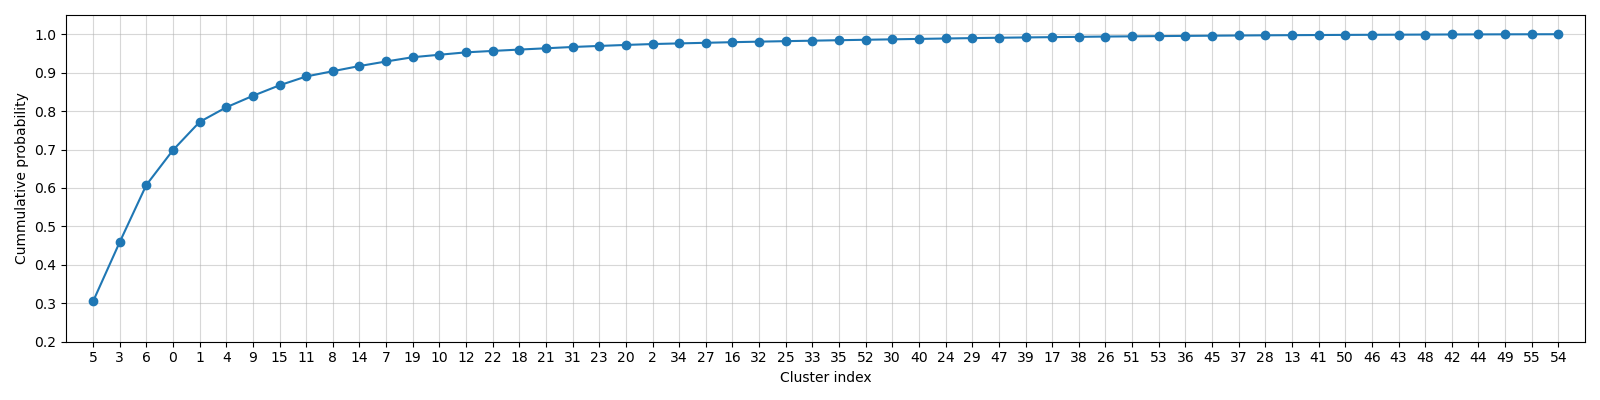

In [31]:
fig, axs = plt.subplots(figsize=(16,4))
ax = axs

xs = [i for i in range(1, numClusters+1)]
#ax.scatter(xs, cum_prob)
ax.plot(xs, cum_prob, linestyle='-', marker='o')

ax.set_xlim(0, numClusters+1)
ax.set_ylim(0.2, 1.05)

xticks = xs
xticklabels = [int(i) for i in cluster_occuring_prob_arr[:,0]]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

ax.set_ylabel('Cummulative probability')
ax.set_xlabel('Cluster index')

ax.grid(alpha=0.5)


fig.tight_layout()

In [26]:
old_picks = [0,1,2,5,3,6,4,11,9,7,10,8,15,14,19]
len(old_picks)

15

In [27]:
5,
3,
6,
0,
1,
4,
15,
9,
11,
8,
7,
14, 
19,
#12,
10,


(10,)

In [28]:
cum_prob[:len(old_picks)]

array([0.30478487, 0.45897936, 0.60778024, 0.69844816, 0.77174288,
       0.80983157, 0.83969673, 0.86711624, 0.89006263, 0.90380221,
       0.91722659, 0.92907935, 0.94017047, 0.94658127, 0.95283636])

In [29]:
cluster_occuring_prob_arr[:len(old_picks),1]

array([0.30478487, 0.15419449, 0.14880088, 0.09066792, 0.07329472,
       0.03808869, 0.02986516, 0.02741951, 0.02294639, 0.01373958,
       0.01342438, 0.01185276, 0.01109112, 0.0064108 , 0.00625508])

In [30]:
0.946742260 - 0.00843471,

(0.93830755,)

In [40]:
xticklabels[:15]

[5, 3, 6, 0, 1, 4, 9, 15, 11, 8, 14, 7, 19, 10, 12]

## version for figure 5:

No handles with labels found to put in legend.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
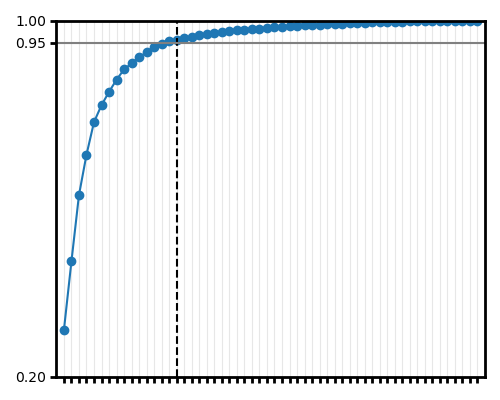

In [37]:
fig, axs = plt.subplots(figsize=(5,4))
ax = axs

xs = [i for i in range(1, numClusters+1)]
#ax.scatter(xs, cum_prob)
ax.plot(xs, cum_prob, linestyle='-', marker='o')

ax.set_xlim(0, numClusters+1)
ax.set_ylim(0.2, 1)

xticks = xs
xticklabels = [int(i) for i in cluster_occuring_prob_arr[:,0]]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

ax.set_ylabel('Cummulative probability')
ax.set_xlabel('Cluster index')

ax.grid(alpha=0.3)

ax.axvline(16, color='black', linestyle='--')
ax.axhline(0.95, color='grey', linestyle='-')

ax.set_yticks([0.2, 0.95, 1])

# ----------
ax.set_xticklabels([])
#ax.set_yticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.legend(fontsize=10, frameon=False, markerscale=10, labelspacing=2, bbox_to_anchor=(0.6,0.9))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.xaxis.set_tick_params(width=2, length=4)
ax.yaxis.set_tick_params(width=2, length=4)

fig.tight_layout()
#fig.savefig('/mnt/e/OneDrive/illustrator_projects/paper_figures/figure5/fig5_los_dwell_new.png', dpi=300, transparent=True)

fig.tight_layout()

No handles with labels found to put in legend.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
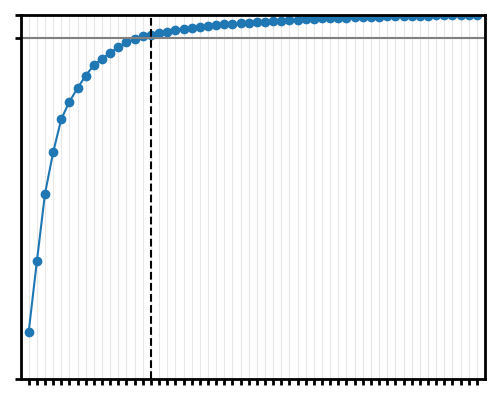

In [38]:
fig, axs = plt.subplots(figsize=(5,4))
ax = axs

xs = [i for i in range(1, numClusters+1)]
#ax.scatter(xs, cum_prob)
ax.plot(xs, cum_prob, linestyle='-', marker='o')

ax.set_xlim(0, numClusters+1)
ax.set_ylim(0.2, 1)

xticks = xs
xticklabels = [int(i) for i in cluster_occuring_prob_arr[:,0]]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

ax.set_ylabel('Cummulative probability')
ax.set_xlabel('Cluster index')

ax.grid(alpha=0.3)

ax.axvline(16, color='black', linestyle='--')
ax.axhline(0.95, color='grey', linestyle='-')

ax.set_yticks([0.2, 0.95, 1])

# ----------
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.legend(fontsize=10, frameon=False, markerscale=10, labelspacing=2, bbox_to_anchor=(0.6,0.9))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.xaxis.set_tick_params(width=2, length=4)
ax.yaxis.set_tick_params(width=2, length=4)

fig.tight_layout()
#fig.savefig('/mnt/e/OneDrive/illustrator_projects/paper_figures/figure5/fig5_occupancy_plot.png', dpi=300, transparent=True)

fig.tight_layout()

# Making an edited set of cluster idx tseries

In [41]:
# So from above, lets use the 15 most common clusters, for about 95% occupancy, and perhaps join some by symmetry arguments
cum_prob[:15]

array([0.30478487, 0.45897936, 0.60778024, 0.69844816, 0.77174288,
       0.80983157, 0.83969673, 0.86711624, 0.89006263, 0.90380221,
       0.91722659, 0.92907935, 0.94017047, 0.94658127, 0.95283636])

In [42]:
cluster_probs = cluster_occuring_prob_arr[:15,1]
cluster_probs

array([0.30478487, 0.15419449, 0.14880088, 0.09066792, 0.07329472,
       0.03808869, 0.02986516, 0.02741951, 0.02294639, 0.01373958,
       0.01342438, 0.01185276, 0.01109112, 0.0064108 , 0.00625508])

In [45]:
original_chosen_cluster_idxs = cluster_occuring_prob_arr[:15,0]
original_chosen_cluster_idxs

array([ 5.,  3.,  6.,  0.,  1.,  4.,  9., 15., 11.,  8., 14.,  7., 19.,
       10., 12.])

In [46]:
# ---- get the distributions for each cluster ---- #

cluster_dppdots_master = []
cluster_phidots_master = []
cluster_pecZ_diff_master = []
cluster_Ozdots_master = []

for clusterIdx in range(numClusters):
    
    cluster_idx_frames_master = np.where(clusterIdx_tseries_master==clusterIdx)[0]
    
    cls_dppdots = dpp_dot_master[cluster_idx_frames_master]
    cls_phidots = phi_dot_master[cluster_idx_frames_master]
    cls_pecZdiffs = pec_z_difference_master[cluster_idx_frames_master]
    cls_Ozdots = Oz_dots_master[cluster_idx_frames_master]

    cluster_dppdots_master.append(cls_dppdots)
    cluster_phidots_master.append(cls_phidots)
    cluster_pecZ_diff_master.append(cls_pecZdiffs)
    cluster_Ozdots_master.append(cls_Ozdots)

In [47]:
# --- set the bins we will use --- #
dpp_dots_bins = np.arange(-20,20+0.25,0.25)
phi_dots_bins = np.arange(-10,10+0.1,0.1)
pec_z_difference_bins = np.arange(-5,5+0.1,0.1)
Oz_dot_bins = np.arange(-10,10+0.1,0.1)

## helpful function for plotting

In [48]:


def plot_summary_of_cluster(clusterIdx):
    ##NB: for now, very dirty use of global vars
    plt.ioff()

    # ---- set-up the main figure information ----- #
    fig = plt.figure(figsize=(10,11)) 
    gs = fig.add_gridspec(13, 10)
    fig.suptitle('Dpp 0-20 cm: ClusterIdx: {0}'.format(clusterIdx))
    gs.update(left=0.04, right=0.96, top=0.90, bottom=0, wspace=0.1, hspace=0)
    #imsavepath = os.path.join(imsavefolderpath,str(clusterIdx).zfill(2))+'.png'

    # --- prepare some data --- #


    # -- plot the 4 histograms --- #

    # dpp-dot
    ax = fig.add_subplot(gs[0:2, 0:5])
    ax.set_title(r'$\dot{D_{pp}}$')
    ax.set_xlabel('[cm/s]')
    ax.hist(cluster_dppdots_master[clusterIdx], bins=dpp_dots_bins, alpha=0.5, density=True, color='red', label='this');
    ax.hist(dpp_dot_master, bins=dpp_dots_bins, density=True, alpha=0.5, color='C0', label='all');
    ax.set_xlim(np.min(dpp_dots_bins), np.max(dpp_dots_bins))
    ax.legend()

    # phi-dot
    ax = fig.add_subplot(gs[3:5, 0:5])
    ax.set_title(r'$\dot{\phi}$')
    ax.set_xlabel('[rad/s]')
    ax.hist(cluster_phidots_master[clusterIdx], bins=phi_dots_bins,  alpha=0.5, color='red', density=True, label='cluster');
    ax.hist(Oz_dots_master, bins=phi_dots_bins, density=True, alpha=0.5, color='C0', label='data');
    ax.set_xlim(np.min(phi_dots_bins), np.max(phi_dots_bins))
    ax.legend()

    # relative Z
    ax = fig.add_subplot(gs[6:8, 0:5])
    ax.set_title(r'$P_{w}(Z) - P_{L}(Z)$')
    ax.set_xlabel('[cm]')
    ax.hist(cluster_pecZ_diff_master[clusterIdx], bins=pec_z_difference_bins, alpha=0.5, density=True, color='red', label='cluster');
    ax.hist(pec_z_difference_master, bins=pec_z_difference_bins, density=True, alpha=0.5, color='C0', label='all');
    ax.set_xlim(np.min(pec_z_difference_bins), np.max(pec_z_difference_bins))
    ax.legend()

    # Oz-dot
    ax = fig.add_subplot(gs[9:11, 0:5])
    ax.set_title(r'$\dot{O_{Z}}$')
    ax.set_xlabel('[cm/s]')
    ax.hist(cluster_Ozdots_master[clusterIdx], bins=Oz_dot_bins, alpha=0.5, density=True, color='red', label='cluster');
    ax.hist(pec_z_difference_master, bins=Oz_dot_bins, density=True, alpha=0.5, color='C0', label='all');
    ax.set_xlim(np.min(Oz_dot_bins), np.max(Oz_dot_bins))
    ax.legend()

    # --- add side view 3D cluster panel --- #
    ax = fig.add_subplot(gs[0:4, 5:11], projection='3d')
    elev = 30
    azim = -60
    ax.view_init(elev, azim)
    cluster_index_list = list(range(numClusters))
    other_cluster_idxs = [x for x in cluster_index_list if x!=clusterIdx]
    # prepare some coordinates, based on the number of bins
    x, y, z = np.indices((num_tetW_bins, num_tetL_bins, num_dpp_bins))
    #  Make the main voxel array 
    voxelarray = np.zeros((num_tetW_bins, num_tetL_bins, num_dpp_bins), dtype=bool)
    # set the colors of the background voxels 
    colors = np.empty((num_tetW_bins, num_tetL_bins, num_dpp_bins,4), dtype=object)
    # the chosen cluster
    cluster_voxels = cluster_state_tuples[clusterIdx]
    cluster_col = [1,0,0,0.4]
    num_cls_voxs = cluster_voxels.shape[0]
    for voxIdx in range(num_cls_voxs):
        vox = cluster_voxels[voxIdx]
        colors[vox[0], vox[1], vox[2]] = cluster_col
        voxelarray[vox[0], vox[1], vox[2]] = True
    # now start the figure
    ax.voxels(voxelarray, facecolors=colors, edgecolor='k');
    ax.set_xlabel(r'$\theta_{W}$')
    ax.set_ylabel(r'$\theta_{L}$')
    ax.set_zlabel(r'D$_{PP}$')
    ax.set_xlim(0, num_tetW_bins)
    ax.set_ylim(0, num_tetL_bins)
    ax.set_zlim(0, num_dpp_bins)
    ax.set_xticks([0, int(num_tetW_bins/4), int(num_tetW_bins/2), int(3*(num_tetW_bins/4)), int(num_tetW_bins) ])
    ax.set_xticklabels([r"-$\pi$", r"-$\pi/2$", r"0", r"$\pi/2$", r"$\pi$"]);
    ax.set_xticks(np.arange(num_tetW_bins+1));
    ax.set_yticks([0, int(num_tetL_bins/4), int(num_tetL_bins/2), int(3*(num_tetL_bins/4)), int(num_tetL_bins) ])
    ax.set_yticklabels([r"-$\pi$", r"-$\pi/2$", r"0", r"$\pi/2$", r"$\pi$"]);
    ax.set_yticks(np.arange(num_tetL_bins+1));
    ax.set_zticks(np.arange(num_dpp_bins+1));
    ax.set_zticklabels(dpp_bins.astype(int), fontsize=4);
    #  Plot the projections of the cluster onto the walls 
    min_x = np.min(cluster_voxels[:,0])
    max_x = np.max(cluster_voxels[:,0])
    min_y = np.min(cluster_voxels[:,1])
    max_y = np.max(cluster_voxels[:,1])
    min_z = np.min(cluster_voxels[:,2])
    max_z = np.max(cluster_voxels[:,2])
    # find the box for the XY plane
    xy_xs = [min_x, min_x, max_x+1, max_x+1, min_x]
    xy_ys = [min_y, max_y+1, max_y+1, min_y, min_y]
    xy_zs = [0, 0, 0, 0, 0]
    ax.plot(xy_xs, xy_ys, xy_zs, color='red')
    # find the box for the XZ plane
    xz_xs = [min_x, min_x, max_x+1, max_x+1, min_x]
    xz_ys = [num_tetL_bins, num_tetL_bins, num_tetL_bins, num_tetL_bins, num_tetL_bins]
    xz_zs = [min_z, max_z+1, max_z+1, min_z, min_z]
    ax.plot(xz_xs, xz_ys, xz_zs, color='red')
    # find the box for the YZ plane
    yz_xs = [0, 0, 0, 0, 0]
    yz_ys = [min_y, min_y, max_y+1, max_y+1, min_y]
    yz_zs = [min_z, max_z+1, max_z+1, min_z, min_z]
    ax.plot(yz_xs, yz_ys, yz_zs, color='red')


    # --- add top-down 3D cluster panel --- #
    ax = fig.add_subplot(gs[5:9, 5:11], projection='3d')
    elev = 90
    azim = -90
    ax.view_init(elev, azim)
    cluster_index_list = list(range(numClusters))
    other_cluster_idxs = [x for x in cluster_index_list if x!=clusterIdx]
    # prepare some coordinates, based on the number of bins
    x, y, z = np.indices((num_tetW_bins, num_tetL_bins, num_dpp_bins))
    #  Make the main voxel array 
    voxelarray = np.zeros((num_tetW_bins, num_tetL_bins, num_dpp_bins), dtype=bool)
    # set the colors of the background voxels 
    colors = np.empty((num_tetW_bins, num_tetL_bins, num_dpp_bins,4), dtype=object)
    # the chosen cluster
    cluster_voxels = cluster_state_tuples[clusterIdx]
    cluster_col = [1,0,0,0.4]
    num_cls_voxs = cluster_voxels.shape[0]
    for voxIdx in range(num_cls_voxs):
        vox = cluster_voxels[voxIdx]
        colors[vox[0], vox[1], vox[2]] = cluster_col
        voxelarray[vox[0], vox[1], vox[2]] = True
    # now start the figure
    ax.voxels(voxelarray, facecolors=colors, edgecolor='k');
    ax.set_xlabel(r'$\theta_{W}$')
    ax.set_ylabel(r'$\theta_{L}$')
    ax.set_zlabel('')
    ax.set_xlim(0, num_tetW_bins)
    ax.set_ylim(0, num_tetL_bins)
    ax.set_zlim(0, num_dpp_bins)
    ax.set_xticks([0, int(num_tetW_bins/4), int(num_tetW_bins/2), int(3*(num_tetW_bins/4)), int(num_tetW_bins) ])
    ax.set_xticklabels([r"-$\pi$", r"-$\pi/2$", r"0", r"$\pi/2$", r"$\pi$"]);
    ax.set_xticks(np.arange(num_tetW_bins+1));
    ax.set_yticks([0, int(num_tetL_bins/4), int(num_tetL_bins/2), int(3*(num_tetL_bins/4)), int(num_tetL_bins) ])
    ax.set_yticklabels([r"-$\pi$", r"-$\pi/2$", r"0", r"$\pi/2$", r"$\pi$"]);
    ax.set_yticks(np.arange(num_tetL_bins+1));
    ax.set_zticks([]);
    #ax.set_zticklabels(dpp_bins.astype(int));


    # --- explanatory figure --- #
    ax = fig.add_subplot(gs[9:12, 6:9])
    ax.set_xlim(-np.pi, np.pi);
    ax.set_ylim(-np.pi, np.pi);
    ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi]);
    ax.set_xticklabels([r"-$\pi$", r"-$\pi/2$", r"0", r"$\pi/2$", r"$\pi$"]);
    ax.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi]);
    ax.set_yticklabels([r"-$\pi$", r"-$\pi/2$", r"0", r"$\pi/2$", r"$\pi$"]);
    # we want to rotate so theta=0 points from origin to y-inf
    image_rot_angle = np.pi/2
    # scale the size of the arrows
    arrfac = 0.2
    # winner-loser-top
    c_x = 0
    c_y = np.pi/2+0.8
    vert_gap = 0.2
    dx_winner = -arrfac*np.cos(c_x + np.pi/2)
    dy_winner = arrfac*np.sin(c_x + np.pi/2)
    dx_loser = arrfac*np.cos(c_y + np.pi/2)
    dy_loser = -arrfac*np.sin(c_y + np.pi/2)
    ax.arrow(c_x, c_y-vert_gap, dx=dx_winner, dy=dy_winner, head_width=0.1, color='red')
    ax.arrow(c_x+0.1, c_y+vert_gap, dx=dx_loser, dy=dy_loser, head_width=0.1, color='blue')
    # winner-loser-bottom
    c_x = 0
    c_y = -(np.pi/2+0.8)
    vert_gap = 0.2
    dx_winner = -arrfac*np.cos(c_x + np.pi/2)
    dy_winner = arrfac*np.sin(c_x + np.pi/2)
    dx_loser = arrfac*np.cos(c_y + np.pi/2)
    dy_loser = -arrfac*np.sin(c_y + np.pi/2)
    ax.arrow(c_x, c_y-vert_gap, dx=dx_winner, dy=dy_winner, head_width=0.1, color='red')
    ax.arrow(c_x-0.1, c_y+vert_gap, dx=dx_loser, dy=dy_loser, head_width=0.1, color='blue')
    # loser-winner-left
    c_x = -(np.pi-0.6)
    c_y = 0
    vert_gap = 0.2
    dx_winner = -arrfac*np.cos(c_x + np.pi/2)
    dy_winner = arrfac*np.sin(c_x + np.pi/2)
    dx_loser = arrfac*np.cos(c_y + np.pi/2)
    dy_loser = -arrfac*np.sin(c_y + np.pi/2)
    ax.arrow(c_x+0.1, c_y-vert_gap, dx=dx_winner, dy=dy_winner, head_width=0.1, color='red')
    ax.arrow(c_x, c_y+vert_gap, dx=dx_loser, dy=dy_loser, head_width=0.1, color='blue')
    # loser-winner-right
    c_x = (np.pi-0.6)
    c_y = 0
    vert_gap = 0.2
    dx_winner = -arrfac*np.cos(c_x + np.pi/2)
    dy_winner = arrfac*np.sin(c_x + np.pi/2)
    dx_loser = arrfac*np.cos(c_y + np.pi/2)
    dy_loser = -arrfac*np.sin(c_y + np.pi/2)
    ax.arrow(c_x-0.1, c_y-vert_gap, dx=dx_winner, dy=dy_winner, head_width=0.1, color='red')
    ax.arrow(c_x, c_y+vert_gap, dx=dx_loser, dy=dy_loser, head_width=0.1, color='blue')
    # face-off
    c_x = 0
    c_y = 0
    vert_gap = 0.4
    dx_winner = arrfac*np.cos(c_x + np.pi/2)
    dy_winner = arrfac*np.sin(c_x + np.pi/2)
    dx_loser = arrfac*np.cos(c_y + np.pi/2)
    dy_loser = -arrfac*np.sin(c_y + np.pi/2)
    ax.arrow(c_x, c_y-vert_gap, dx=dx_winner, dy=dy_winner, head_width=0.1, color='red')
    ax.arrow(c_x, c_y+vert_gap, dx=dx_loser, dy=dy_loser, head_width=0.1, color='blue')
    # parallel WRE (top-left)
    c_x = -np.pi/2
    c_y = np.pi/2
    vert_gap = 0.1
    dx_winner = -arrfac*np.cos(c_x + np.pi/2)
    dy_winner = arrfac*np.sin(c_x + np.pi/2)
    dx_loser = arrfac*np.cos(c_y + np.pi/2)
    dy_loser = -arrfac*np.sin(c_y + np.pi/2)
    ax.arrow(c_x+0.1, c_y-vert_gap, dx=dx_winner, dy=dy_winner, head_width=0.1, color='red')
    ax.arrow(c_x+0.1, c_y+vert_gap, dx=dx_loser, dy=dy_loser, head_width=0.1, color='blue')
    # parallel WLE (bottom-right)
    c_x = np.pi/2
    c_y = -np.pi/2
    vert_gap = 0.1
    dx_winner = -arrfac*np.cos(c_x + np.pi/2)
    dy_winner = arrfac*np.sin(c_x + np.pi/2)
    dx_loser = arrfac*np.cos(c_y + np.pi/2)
    dy_loser = -arrfac*np.sin(c_y + np.pi/2)
    ax.arrow(c_x-0.1, c_y-vert_gap, dx=dx_winner, dy=dy_winner, head_width=0.1, color='red')
    ax.arrow(c_x-0.1, c_y+vert_gap, dx=dx_loser, dy=dy_loser, head_width=0.1, color='blue')
    # anti-parallel WLE (top-left)
    c_x = np.pi/2
    c_y = np.pi/2
    horz_gap = 0.15
    dx_winner = -arrfac*np.cos(c_x + np.pi/2)
    dy_winner = arrfac*np.sin(c_x + np.pi/2)
    dx_loser = arrfac*np.cos(c_y + np.pi/2)
    dy_loser = -arrfac*np.sin(c_y + np.pi/2)
    ax.arrow(c_x-horz_gap, c_y-vert_gap, dx=dx_winner, dy=dy_winner, head_width=0.1, color='red')
    ax.arrow(c_x+horz_gap, c_y+vert_gap, dx=dx_loser, dy=dy_loser, head_width=0.1, color='blue')
    # anti-parallel RE (bottom-right)
    c_x = -np.pi/2
    c_y = -np.pi/2
    horz_gap = 0.15
    dx_winner = -arrfac*np.cos(c_x + np.pi/2)
    dy_winner = arrfac*np.sin(c_x + np.pi/2)
    dx_loser = arrfac*np.cos(c_y + np.pi/2)
    dy_loser = -arrfac*np.sin(c_y + np.pi/2)
    ax.arrow(c_x+horz_gap, c_y-vert_gap, dx=dx_winner, dy=dy_winner, head_width=0.1, color='red')
    ax.arrow(c_x-horz_gap, c_y+vert_gap, dx=dx_loser, dy=dy_loser, head_width=0.1, color='blue')

    plt.ion()
    return fig

In [49]:
original_chosen_cluster_idxs

array([ 5.,  3.,  6.,  0.,  1.,  4.,  9., 15., 11.,  8., 14.,  7., 19.,
       10., 12.])

## main plots for investigating clusters

In [62]:
cluster_figs = []

imsavefolder = '/media/liam/hd1/fighting_data/infomap_data/infomap_cluster_ims/'

for clusterIdx in cluster_occuring_prob_arr[:25,0]:
    print(clusterIdx)
    clusterIdx = int(clusterIdx)
    fig = plot_summary_of_cluster(clusterIdx)
    sp = os.path.join(imsavefolder, '{0}.png'.format(clusterIdx))
    dpi=300
    fig.savefig(sp, dpi=dpi, transparent=False, bbox_inches='tight', pad_inches=0.5)
    #cluster_figs.append(fig)

5.0
3.0
6.0
0.0
1.0
4.0
9.0
15.0
11.0
8.0
14.0
7.0
19.0
10.0
12.0
22.0
18.0


/tmp/ipykernel_1702883/2247939510.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10,11))


21.0
31.0
23.0
20.0
2.0
34.0
27.0
16.0


In [63]:
# grab the image paths to combine
imagepaths = glob.glob(imsavefolder+'/*.png')
imagepaths.sort()

# set the output path
pdfsavepath =  os.path.join(imsavefolder,'all_clusters.pdf')
pdfsavepath

'/media/liam/hd1/fighting_data/infomap_data/infomap_cluster_ims/all_clusters.pdf'

In [64]:
with open(pdfsavepath,"wb") as f:
    f.write(img2pdf.convert(imagepaths))

Image contains an alpha channel which will be stored as a separate soft mask (/SMask) image in PDF.
Image contains an alpha channel which will be stored as a separate soft mask (/SMask) image in PDF.
Image contains an alpha channel which will be stored as a separate soft mask (/SMask) image in PDF.
Image contains an alpha channel which will be stored as a separate soft mask (/SMask) image in PDF.
Image contains an alpha channel which will be stored as a separate soft mask (/SMask) image in PDF.
Image contains an alpha channel which will be stored as a separate soft mask (/SMask) image in PDF.
Image contains an alpha channel which will be stored as a separate soft mask (/SMask) image in PDF.
Image contains an alpha channel which will be stored as a separate soft mask (/SMask) image in PDF.
Image contains an alpha channel which will be stored as a separate soft mask (/SMask) image in PDF.
Image contains an alpha channel which will be stored as a separate soft mask (/SMask) image in PDF.


## keeping record of what we will change and update

In [66]:
original_cluster_idxs = []
edited_cluster_idxs = []
cluster_names = []

# close antiparallel swimming will be new zero idx, 
# and gets clusterIdxs 0 and 1
original_cluster_idxs.append(0)
edited_cluster_idxs.append(0)
original_cluster_idxs.append(1)
edited_cluster_idxs.append(0)
cluster_names.append('circling')

# swimming away will be new 1 index
# and gets clusterIdxs 2
original_cluster_idxs.append(2)
edited_cluster_idxs.append(1)
cluster_names.append('direct away')


# close winner attack will be new 2 index
# and gets clusterIdxs 5
original_cluster_idxs.append(5)
edited_cluster_idxs.append(2)
cluster_names.append('winner attack')


# close loser attack will be new 3 index
# and gets clusterIdxs 3,6
original_cluster_idxs.append(3)
edited_cluster_idxs.append(3)
original_cluster_idxs.append(6)
edited_cluster_idxs.append(3)
cluster_names.append('loser attack')


# close parallel with be new 4 index,
# and gets clusterIdxs 4 and 11
original_cluster_idxs.append(4)
edited_cluster_idxs.append(4)
original_cluster_idxs.append(11)
edited_cluster_idxs.append(4)
cluster_names.append('display')

# close direct approach will be new index 5,
# and will get clusteridx 9
original_cluster_idxs.append(9)
edited_cluster_idxs.append(5)
cluster_names.append('direct approach (close)')


# anti-parallel 4-8cm will be new index 6,
# and will get clusteridx 7,10
original_cluster_idxs.append(7)
edited_cluster_idxs.append(6)
original_cluster_idxs.append(10)
edited_cluster_idxs.append(6)
cluster_names.append('middle circling')


# middle distance loser approach will be new index 7,
# and will get clusteridx 8,15
original_cluster_idxs.append(8)
edited_cluster_idxs.append(7)
original_cluster_idxs.append(15)
edited_cluster_idxs.append(7)
cluster_names.append('loser approach')


# middle distance winner approach will be new index 8,
# and will get clusteridx 14,19
original_cluster_idxs.append(14)
edited_cluster_idxs.append(8)
original_cluster_idxs.append(19)
edited_cluster_idxs.append(8)
cluster_names.append('winner approach')


# parallel will be new index 9,
# and will get clusteridx 12
original_cluster_idxs.append(12)
edited_cluster_idxs.append(9)
cluster_names.append('parallel')




# make a dataframe of updates
column_names = ['clusterIdx', 'edited clusterIdx']
update_df = pd.DataFrame(data=np.stack((original_cluster_idxs, edited_cluster_idxs), axis=1), columns=column_names)
update_df

,clusterIdx,edited clusterIdx
0,0,0
1,1,0
2,2,1
3,5,2
4,3,3
5,6,3
6,4,4
7,11,4
8,9,5
9,7,6


In [70]:
# save the information for this dataFrame
infomap_edited_cluster_info_path = os.path.join( os.path.dirname(os.path.dirname(main_load_folder)) , 
                                                  'infomap_data/editing_clusterIdx_info.h5')
with h5py.File(infomap_edited_cluster_info_path, 'w') as hf:
    hf.create_dataset('original_cluster_idxs', data=original_cluster_idxs)
    hf.create_dataset('edited_cluster_idxs', data=edited_cluster_idxs)

## create the new timeseries

In [81]:
# We have already applied the raw infomap clustering, to generate clusterIdx tseries for each experiment.
# Now we want to edit these, using the above information

In [43]:
len(all_exps_clusterIdx_tseries)

22

### compute

In [44]:
t0 = time.time()

# how many assignings did we make above
numClusterAssignments = update_df.shape[0]

# create a new list to hold the results for each experiment
all_exps_edited_clusterIdx_tseries = []

for expIdx in range(len(all_exps_clusterIdx_tseries)):
    # get the old tseries for parsing
    old_tseries = np.copy(all_exps_clusterIdx_tseries[expIdx])
    # preallocate an array to hold the new results for this experiment
    new_tseries = np.ones_like(all_exps_clusterIdx_tseries[expIdx])*-1
    # the new tseries is all -1.
    # make it NaN where the old one was Nan, and then assign the new clusteridxs where appropriate
    new_tseries[np.isnan(old_tseries)] = np.NaN
    for rowIdx in range(numClusterAssignments):
        oldIdx = update_df['clusterIdx'].iloc[rowIdx]
        newIdx = update_df['edited clusterIdx'].iloc[rowIdx]
        new_tseries[old_tseries==oldIdx] = newIdx
    all_exps_edited_clusterIdx_tseries.append(new_tseries)

# --- save ----- #
# save next to the 'raw' clusterIdx tseries
all_exp_edited_cluster_tseries_savepath = os.path.join(os.path.dirname(loadpath), 'exp_edited_clusterIdx_timeseries.h5')
with h5py.File(all_exp_edited_cluster_tseries_savepath, 'w') as hf:
    for expIdx in range(len(expNames)):
        expName = expNames[expIdx]
        hf.create_dataset('{0}_clusterIdxs'.format(expName), data=all_exps_edited_clusterIdx_tseries[expIdx])

        
tE = time.time()
print(tE-t0)

0.3532085418701172


### load

In [45]:
# load
all_exps_edited_clusterIdx_tseries = []
all_exp_edited_cluster_tseries_savepath = os.path.join(os.path.dirname(loadpath), 'exp_edited_clusterIdx_timeseries.h5')
with h5py.File(all_exp_edited_cluster_tseries_savepath, 'r') as hf:
    for expIdx in range(len(expNames)):
        expName = expNames[expIdx]
        exp_cls_tseries = hf['{0}_clusterIdxs'.format(expName)][:]
        all_exps_edited_clusterIdx_tseries.append(exp_cls_tseries)
        
# make the master-set
clusterIdx_edited_tseries_master = np.concatenate(all_exps_edited_clusterIdx_tseries)
clusterIdx_edited_tseries_master.shape

(16044324,)

## Post-process the new timeseries

In [46]:
clusterIdx_edited_tseries_master[~np.isnan(clusterIdx_edited_tseries_master)].shape

(14163469,)

In [47]:
np.unique(clusterIdx_edited_tseries_master[~np.isnan(clusterIdx_edited_tseries_master)])

array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [48]:
clusterIdx_edited_tseries_master.shape

(16044324,)

In [49]:
numLabelledClusters = len(cluster_names)
numLabelledClusters

10

In [ ]:
# the most common dwelling time is 1 frame.
# let's reintroduce post-processing like we did in the past

In [50]:
print(len(all_exps_edited_clusterIdx_tseries))
print(clusterIdx_edited_tseries_master.shape)

22
(16044324,)


In [51]:
# --- params --- #
MINSIZE = 5  # remove any contiguous regions smaller than MINSIZE
MAXGAP= 5   # join together contiguous regions of same clusterIdx separated by less than MAXGAP frames

# first remove small regions
# then join regions 

In [52]:
# --- Make a list of post-processed edited clusterIdx tseries --- #
# this will be updated in the coming sections
all_exps_edited_postProced_clusterIdx_tseries = []
for expIdx in range(len(expNames)):
    edited_postProced_cls_ts = np.copy(all_exps_edited_clusterIdx_tseries[expIdx])
    all_exps_edited_postProced_clusterIdx_tseries.append(edited_postProced_cls_ts)
    

In [ ]:
## FOR NOW, FORGET REMOVING SMALL GAPS

In [140]:
# # --- Remove small contiguous regions --- #
# # MINSIZE

# for expIdx in range(len(expNames)):
#     # dont make a copy, because we want to edit the entries of all_exps_edited_postProced_clusterIdx_tseries
#     exp_edited_postProced_cls_ts = all_exps_edited_postProced_clusterIdx_tseries[expIdx]

#     # loop over clusterIdxs, leaving -1 alone
#     for clusterIdx in range(numLabelledClusters):
        
#         # create a binary array
#         exp_clIdx_bin_arr = exp_edited_postProced_cls_ts == clusterIdx

#         # get the regions and lenghts
#         regions = contiguous_regions(exp_clIdx_bin_arr)
#         lengths = np.diff(regions, axis=1)[:,0]

#         # NaN any regions smaller than MINSIZE in original array
#         for regIdx in range(regions.shape[0]):
#             regSize = lengths[regIdx]
#             r0,rF = regions[regIdx]
#             if regSize < MINSIZE:
#                 exp_edited_postProced_cls_ts[r0:rF] = np.NaN



In [141]:
# # plot histograms of the contiguous region occupancies


# clusterIdx_edited_postProced_tseries_master = np.concatenate(all_exps_edited_postProced_clusterIdx_tseries)

# post_processed_cluster_regions_sizes = []

# for clIdx in range(numLabelledClusters):
#     # get a bool array representing true for this clusterIdx
#     clIdx_boolarr = clusterIdx_edited_postProced_tseries_master == clIdx
#     # get the contiguous regions of this bool array
#     cl_regions = contiguous_regions(clIdx_boolarr)
#     # get the size of the regions
#     cl_region_sizes = np.diff(cl_regions, axis=1).reshape(-1)
#     post_processed_cluster_regions_sizes.append(cl_region_sizes)

# occupancy_bins = [np.arange(0, 50, 1)]*numLabelledClusters

# fig, axs = plt.subplots(nrows=numLabelledClusters, figsize=(10,15))
# fig.suptitle('Histogram of cluster dwell times\n\n')

# for clIdx in range(numLabelledClusters):
#     ax = axs[clIdx]
#     ax.set_title(cluster_names[clIdx])
#     ax.hist(post_processed_cluster_regions_sizes[clIdx], bins=occupancy_bins[clIdx], density=True)
#     ax.axvline(np.nanmean(post_processed_cluster_regions_sizes[clIdx]))
#     ax.set_xlabel('frames')
#     ax.set_xticks([i*5 for i in range(11)])
    
# # set xlabel on last plot
# axs[-1].set_xlabel('frames')
    
# fig.tight_layout()

In [55]:
# --- Merge contiguous regions with smaller separations --- #
# MAXGAP


for expIdx in range(len(expNames)):
    # dont make a copy, because we want to edit the entries of all_exps_edited_postProced_clusterIdx_tseries
    exp_edited_postProced_cls_ts = all_exps_edited_postProced_clusterIdx_tseries[expIdx]
    
    # loop over clusters, ignoring -1
    for clusterIdx in range(numLabelledClusters):
        # create a binary array, and the inverse binary array
        # (where clusterIdx is, and where clusterIdx isn't )
        exp_clIdx_bin_arr_original = exp_edited_postProced_cls_ts == clusterIdx
        exp_clIdx_bin_arr_inverse = ~exp_clIdx_bin_arr_original
        
        # get the regions, and lengths, of the inverse,
        # where these regions are now contiguous gaps between clusterIdx contiguous regions
        inverse_region_data = contiguous_regions(exp_clIdx_bin_arr_inverse)
        inverse_region_lengths = np.diff(inverse_region_data, axis=1)[:,0]
        
        #---- Apply MAXGAP --- #
        # join contiguous regions which are separated by less than MAXGAP
        for regionIdx in range(inverse_region_lengths.shape[0]):
            if inverse_region_lengths[regionIdx] <= MAXGAP:
                f0, fE = inverse_region_data[regionIdx]
                exp_edited_postProced_cls_ts[f0:fE] = clusterIdx
        

In [143]:
# # plot histograms of the contiguous region occupancies


# clusterIdx_edited_postProced_tseries_master = np.concatenate(all_exps_edited_postProced_clusterIdx_tseries)

# post_processed_cluster_regions_sizes = []

# for clIdx in range(numLabelledClusters):
#     # get a bool array representing true for this clusterIdx
#     clIdx_boolarr = clusterIdx_edited_postProced_tseries_master == clIdx
#     # get the contiguous regions of this bool array
#     cl_regions = contiguous_regions(clIdx_boolarr)
#     # get the size of the regions
#     cl_region_sizes = np.diff(cl_regions, axis=1).reshape(-1)
#     post_processed_cluster_regions_sizes.append(cl_region_sizes)

# occupancy_bins = [np.arange(0, 150, 1)]*numLabelledClusters

# fig, axs = plt.subplots(nrows=numLabelledClusters, figsize=(10,15))
# fig.suptitle('Histogram of cluster dwell times\n\n')

# for clIdx in range(numLabelledClusters):
#     ax = axs[clIdx]
#     ax.set_title(cluster_names[clIdx])
#     ax.hist(post_processed_cluster_regions_sizes[clIdx], bins=occupancy_bins[clIdx], density=True, log=True, alpha=0.5)
#     ax.axvline(np.nanmean(post_processed_cluster_regions_sizes[clIdx]))
#     ax.set_xlabel('frames')
#     ax.set_xticks([5]+[i*10 for i in range(16)])
    
# # set xlabel on last plot
# axs[-1].set_xlabel('frames')
    
# fig.tight_layout()

In [56]:
# --- save ----- #
# save next to the 'raw' clusterIdx tseries
postprocessed_all_exp_edited_cluster_tseries_savepath = os.path.join(os.path.dirname(loadpath), 'postprocessed_exp_edited_clusterIdx_timeseries.h5')
with h5py.File(postprocessed_all_exp_edited_cluster_tseries_savepath, 'w') as hf:
    for expIdx in range(len(expNames)):
        expName = expNames[expIdx]
        hf.create_dataset('{0}_clusterIdxs'.format(expName), data=all_exps_edited_postProced_clusterIdx_tseries[expIdx])

In [156]:
postprocessed_all_exp_edited_cluster_tseries_savepath 

'/mnt/e/dataspace/post_processing_infomap/20220119_computation_dppMax_020/postprocessed_exp_edited_clusterIdx_timeseries.h5'

In [57]:
# load
all_exps_edited_postProced_clusterIdx_tseries = []
postprocessed_all_exp_edited_cluster_tseries_savepath = os.path.join(os.path.dirname(loadpath), 'postprocessed_exp_edited_clusterIdx_timeseries.h5')
with h5py.File(postprocessed_all_exp_edited_cluster_tseries_savepath, 'r') as hf:
    for expIdx in range(len(expNames)):
        expName = expNames[expIdx]
        tseries = hf['{0}_clusterIdxs'.format(expName)][:]
        all_exps_edited_postProced_clusterIdx_tseries.append(tseries)
        
# make the master-set
clusterIdx_edited_postProced_tseries_master = np.concatenate(all_exps_edited_postProced_clusterIdx_tseries)
clusterIdx_edited_postProced_tseries_master.shape

(16044324,)